In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_parquet
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE

In [459]:
dataframe = read_parquet('kline_data/kline_data/train_data/1000FLOKIUSDT.parquet')
dataframe.head(5)

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount
0,1683390600000,0.0423100,0.0444600,0.0423100,0.0432000,91614205,3986427.2652500,16405,46218295,2010734.9819600
1,1683391500000,0.0431900,0.0437500,0.0428700,0.0433200,61141456,2646329.8671100,11214,31271274,1353742.8878800
2,1683392400000,0.0433200,0.0436500,0.0429000,0.0432000,51385122,2223310.8747900,8909,26248343,1135844.9290600
3,1683393300000,0.0432100,0.0433000,0.0423900,0.0428600,54321490,2329436.1780000,9208,25720153,1103324.2959700
4,1683394200000,0.0428500,0.0434700,0.0426500,0.0429500,37486122,1616366.3676500,7528,18928398,816380.6000400


In [460]:
tf.random.set_seed(2025)

In [461]:
dataframe = dataframe.astype(np.float32)

In [462]:
dataframe['feature0'] = (dataframe['close_price'] - dataframe['open_price']) / dataframe['open_price']
dataframe['feature1'] = (dataframe['high_price'] - dataframe['low_price']) / dataframe['close_price']
dataframe['feature2'] = dataframe['buy_volume'] / (dataframe['volume'] - dataframe['buy_volume'])
dataframe['feature3'] = dataframe['amount'] / dataframe['volume']
dataframe['feature4'] = dataframe['buy_amount'] / dataframe['buy_volume']

In [463]:
dataframe['rolling_max'] = dataframe['high_price'].expanding(min_periods=1).max()
dataframe['rolling_min'] = dataframe['low_price'].expanding(min_periods=1).min()
for window in [3, 6, 9, 12, 15]:
    dataframe[f'sma_{window}'] = dataframe['close_price'].expanding(min_periods=1).mean()
    if window > 1:
        # 从第window个位置开始使用滚动平均值
        dataframe[f'sma_{window}'].iloc[window-1:] = dataframe['close_price'].rolling(window=window).mean().iloc[window-1:]
    
     # 2. 移动波动率 (N周期内最高价与最低价之差)
    # 使用累积最大值/最小值填充初始值
    
    dataframe[f'rolling_volatility_{window}'] = (dataframe['rolling_max'] - dataframe['rolling_min']) / dataframe['close_price']
    if window > 1:
        # 从第window个位置开始使用滚动窗口计算
        rolling_max = dataframe['high_price'].rolling(window=window).max()
        rolling_min = dataframe['low_price'].rolling(window=window).min()
        valid_indices = rolling_max.index[window-1:]
        dataframe.loc[valid_indices, f'rolling_volatility_{window}'] = (
            (rolling_max - rolling_min) / dataframe['close_price']
        ).loc[valid_indices]
    
    # 3. 量能变化率 (当前成交量与前一期成交量变化率)
    dataframe[f'volume_change_{window}'] = 0.0  # 初始化
    # 从第二个数据点开始计算
    if len(dataframe) > 1:
        prev_volume = dataframe['volume'].shift(1)
        volume_change = (dataframe['volume'] - prev_volume) / prev_volume.replace(0, 1)
        dataframe[f'volume_change_{window}'].iloc[1:] = volume_change.iloc[1:]
    
    # 4. 价格-量能背离指标
    dataframe[f'divergence_{window}'] = 0.0  # 初始化
    # 从第二个数据点开始计算
    if len(dataframe) > 1:
        # 价格变化方向 (1=上涨, -1=下跌)
        price_dir = np.sign(dataframe['close_price'] - dataframe['close_price'].shift(1))
        # 量能变化方向 (1=增加, -1=减少)
        volume_dir = np.sign(dataframe['volume'] - dataframe['volume'].shift(1))
        dataframe[f'divergence_{window}'].iloc[1:] = price_dir.iloc[1:] * volume_dir.iloc[1:]

C:\Users\41582\AppData\Local\Temp\ipykernel_26796\534169257.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataframe[f'sma_{window}'].iloc[window-1:] = dataframe['close_price'].rolling(window=window).mean().iloc[window-1:]
C:\Users\4158

In [464]:
dataframe.describe()

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount,...,volume_change_9,divergence_9,sma_12,rolling_volatility_12,volume_change_12,divergence_12,sma_15,rolling_volatility_15,volume_change_15,divergence_15
count,5.807800e+04,58078.000000,58078.000000,58078.000000,58078.000000,5.807800e+04,5.807800e+04,58078.000000,5.807800e+04,5.807800e+04,...,58078.000000,58078.000000,58078.000000,58078.000000,58078.000000,58078.000000,58078.000000,58078.000000,58078.000000,58078.000000
mean,1.709525e+12,0.104374,0.104966,0.103785,0.104376,1.334458e+07,1.572438e+06,7152.956055,6.535440e+06,7.686268e+05,...,0.216422,-0.009229,0.104363,0.034317,0.216422,-0.009229,0.104359,0.038620,0.216422,-0.009229
std,1.508987e+10,0.083461,0.084022,0.082907,0.083461,3.043106e+07,3.500511e+06,12862.773438,1.532683e+07,1.735618e+06,...,1.587895,0.986775,0.083444,0.029448,1.587895,0.986775,0.083440,0.032638,1.587895,0.986775
min,1.683391e+12,0.015330,0.015380,0.015120,0.015330,6.806100e+04,1.612593e+03,37.000000,2.335600e+04,3.687912e+02,...,-0.994567,-1.000000,0.015397,0.003169,-0.994567,-1.000000,0.015399,0.003578,-0.994567,-1.000000
25%,1.696458e+12,0.028430,0.028550,0.028320,0.028433,3.255002e+06,1.128216e+05,803.000000,1.556360e+06,5.398098e+04,...,-0.309203,-1.000000,0.028457,0.017345,-0.309203,-1.000000,0.028460,0.019553,-0.309203,-1.000000
50%,1.709525e+12,0.113255,0.113715,0.112655,0.113260,6.187208e+06,5.545940e+05,3185.500000,2.983830e+06,2.684660e+05,...,-0.033691,-0.000000,0.113268,0.026078,-0.033691,-0.000000,0.113261,0.029605,-0.033691,-0.000000
75%,1.722593e+12,0.171898,0.172770,0.171077,0.171900,1.261780e+07,1.624687e+06,8167.750000,6.163021e+06,7.898633e+05,...,0.389051,1.000000,0.171955,0.041064,0.389051,1.000000,0.171976,0.046185,0.389051,1.000000
max,1.735660e+12,0.345020,0.349290,0.340230,0.345090,1.323368e+09,1.576538e+08,425066.000000,7.153520e+08,7.900835e+07,...,191.293884,1.000000,0.334487,0.527254,191.293884,1.000000,0.333475,0.539832,191.293884,1.000000


In [465]:
dataframe = dataframe.dropna(axis=0)

In [466]:
# 1. 检查整个数据集是否有NaN
print("数据集是否包含NaN:", dataframe.isnull().values.any())

# 2. 统计每列的NaN数量
nan_counts = dataframe.isnull().sum()
print("\n各列NaN值统计:")
print(nan_counts)

# 3. 查看NaN值占比
nan_percent = dataframe.isnull().mean() * 100
print("\n各列NaN值占比(%):")
print(nan_percent.round(2))

数据集是否包含NaN: False

各列NaN值统计:
timestamp                0
open_price               0
high_price               0
low_price                0
close_price              0
volume                   0
amount                   0
count                    0
buy_volume               0
buy_amount               0
feature0                 0
feature1                 0
feature2                 0
feature3                 0
feature4                 0
rolling_max              0
rolling_min              0
sma_3                    0
rolling_volatility_3     0
volume_change_3          0
divergence_3             0
sma_6                    0
rolling_volatility_6     0
volume_change_6          0
divergence_6             0
sma_9                    0
rolling_volatility_9     0
volume_change_9          0
divergence_9             0
sma_12                   0
rolling_volatility_12    0
volume_change_12         0
divergence_12            0
sma_15                   0
rolling_volatility_15    0
volume_change_15         0

In [467]:
dataset = dataframe.values
dataset = np.delete(dataset, 0, axis=1)
dataset = dataset.astype('float32')

In [468]:
diff = np.full((len(dataset)), np.nan)
diff[1:] = dataset[1:, 3] - dataset[:-1, 3]
diff[0] = 0
terciles = np.percentile(diff, [33.3, 66.7])
print("第一个三分位点 (33.3%):", terciles[0])
print("第二个三分位点 (66.7%):", terciles[1])
y = np.full((len(dataset)), np.nan)
for i in range(len(dataset) - 1):
    y[i + 1] = 0 if diff[i + 1] < - 1.5e-4 else (1 if diff[i + 1] < 1.5e-4 else 2)
y[0] = 0
print(y[:5])

第一个三分位点 (33.3%): -8.999928832054138e-05
第二个三分位点 (66.7%): 8.00006091594696e-05
[0. 1. 1. 0. 1.]


In [469]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [470]:
print(dataset[:5])

[[0.08183445 0.08708933 0.08363324 0.08451601 0.0691802  0.02527599
  0.03851032 0.06457863 0.0254451  0.6651115  0.11001364 0.03680691
  0.08577658 0.08573532 0.         1.0000001  0.08527607 0.10593498
  0.00517227 0.5        0.08634336 0.10039167 0.00517227 0.5
  0.08685061 0.09425351 0.00517227 0.5        0.08713321 0.08891684
  0.00517227 0.5        0.0874026  0.08613561 0.00517227 0.5       ]
 [0.08450362 0.08496301 0.08535574 0.08487991 0.04615235 0.01677565
  0.02629703 0.0436833  0.01712959 0.6164497  0.04411921 0.03792282
  0.08507328 0.08508132 0.         1.0000001  0.08545987 0.10563387
  0.00344247 0.         0.08652961 0.10009883 0.00344247 0.
  0.08703798 0.0939784  0.00344247 0.         0.08732124 0.08865379
  0.00344247 0.         0.08759123 0.08587852 0.00344247 0.        ]
 [0.08489794 0.08466353 0.085448   0.08451601 0.03877962 0.01409241
  0.02087387 0.03666145 0.01437166 0.60084563 0.03751338 0.03781874
  0.0850292  0.08502869 0.         1.0000001  0.0853986  0.10

In [471]:
dataset = dataset[:-1]
y = y[1:]
print(dataset.shape)
print(y.shape)

(58077, 36)
(58077,)


In [472]:
smote = SMOTE(random_state=2025)
dataset_smote, y_smote = smote.fit_resample(dataset, y)

In [473]:
print(dataset_smote.shape)
print(y_smote.shape)

(78924, 36)
(78924,)


In [474]:
X_train, X_test, y_train, y_test = train_test_split(dataset_smote, y_smote, test_size=0.2)

In [475]:
# 构建模型集成
lgbm_model = LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.6, random_state=2025, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, colsample_bytree=0.8)
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.6, random_state=2025, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, colsample_bytree=0.8)
catboost_model = CatBoostClassifier(n_estimators=200, max_depth=10, learning_rate=0.6, random_state=2025, verbose=0, l2_leaf_reg=5, rsm=0.8) # 构建基模型，并加入正则化和降低复杂度

# 集成模型：StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('lgbm', lgbm_model), ('xgb', xgb_model), ('catboost', catboost_model)],
    final_estimator=LGBMClassifier(n_estimators=25, random_state=2025)
)

In [476]:
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7849
[LightGBM] [Info] Number of data points in the train set: 63139, number of used features: 36
[LightGBM] [Info] Start training from score -1.097773
[LightGBM] [Info] Start training from score -1.099436
[LightGBM] [Info] Start training from score -1.098628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7848
[LightGBM] [Info] Number of data points in the train set: 50511, number of used features: 36
[LightGBM] [Info] Start training from score -1.097781
[LightGBM] [Info] Start training from score -1.099385
[LightGBM] [Info] Start training from score -1.098672


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7757
[LightGBM] [Info] Number of data points in the train set: 50511, number of used features: 36
[LightGBM] [Info] Start training from score -1.097781
[LightGBM] [Info] Start training from score -1.099444
[LightGBM] [Info] Start training from score -1.098612


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7755
[LightGBM] [Info] Number of data points in the train set: 50511, number of used features: 36
[LightGBM] [Info] Start training from score -1.097781
[LightGBM] [Info] Start training from score -1.099444
[LightGBM] [Info] Start training from score -1.098612


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7758
[LightGBM] [Info] Number of data points in the train set: 50511, number of used features: 36
[LightGBM] [Info] Start training from score -1.097781
[LightGBM] [Info] Start training from score -1.099444
[LightGBM] [Info] Start training from score -1.098612


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7837
[LightGBM] [Info] Number of data points in the train set: 50512, number of used features: 36
[LightGBM] [Info] Start training from score -1.097742
[LightGBM] [Info] Start training from score -1.099464
[LightGBM] [Info] Start training from score -1.098632


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 63139, number of used features: 9
[LightGBM] [Info] Start training from score -1.097773
[LightGBM] [Info] Start training from score -1.099436
[LightGBM] [Info] Start training from score -1.098628


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(colsample_bytree=0.8,
                                               learning_rate=0.6, max_depth=10,
                                               n_estimators=200,
                                               random_state=2025, reg_alpha=0.5,
                                               reg_lambda=0.5, subsample=0.8)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x0000025291FE7260>)],
                   final_estimator=LGBMClassifier(n_estimators=25,
                                                  random_state=2025))

In [477]:
y_pred = stacking_model.predict(X_test)

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [478]:
print(y_pred[:5])

[0. 1. 0. 2. 1.]


In [479]:
print("分类报告：")
print(classification_report(y_test, y_pred, target_names=["下跌", "不变", "上涨"]))

分类报告：
              precision    recall  f1-score   support

          下跌       0.64      0.64      0.64      5244
          不变       0.81      0.80      0.81      5279
          上涨       0.64      0.64      0.64      5262

    accuracy                           0.69     15785
   macro avg       0.69      0.69      0.69     15785
weighted avg       0.70      0.69      0.69     15785



In [480]:
y_pred_train = stacking_model.predict(X_train)

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [481]:
print("分类报告：")
print(classification_report(y_train, y_pred_train, target_names=["下跌", "不变", "上涨"]))

分类报告：
              precision    recall  f1-score   support

          下跌       1.00      1.00      1.00     21064
          不变       1.00      1.00      1.00     21029
          上涨       1.00      1.00      1.00     21046

    accuracy                           1.00     63139
   macro avg       1.00      1.00      1.00     63139
weighted avg       1.00      1.00      1.00     63139



In [482]:
y_pred_primitive = stacking_model.predict(dataset)
print("分类报告：")
print(classification_report(y, y_pred_primitive, target_names=["下跌", "不变", "上涨"]))

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


分类报告：
              precision    recall  f1-score   support

          下跌       0.91      0.91      0.91     16198
          不变       0.97      0.96      0.96     26308
          上涨       0.90      0.91      0.91     15571

    accuracy                           0.93     58077
   macro avg       0.93      0.93      0.93     58077
weighted avg       0.93      0.93      0.93     58077



D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

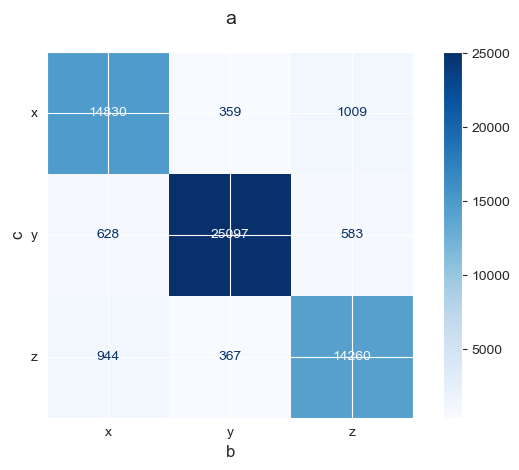

In [434]:
# 混淆矩阵显示
plt.figure(figsize=(8, 6), dpi=100)
conf_matrix = confusion_matrix(y, y_pred_primitive, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["x", "y", "z"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('a', fontsize=14, pad=20)
plt.xlabel('b', fontsize=12)
plt.ylabel('c', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()